1. Add folders in graphs for species
2. Export confusion matrices

# Iris Classification

Author: Tessa Chessnoe<br>
Original Submission Date: 10-21-24<br>
Last Updated: 12-7-25<br>
Dataset Link: https://archive.ics.uci.edu/dataset/53/iris


# 0. Global Constants

In [3]:
# Set random state to 0 for reproducibility
rs = 0

# 1. Import Dataset

In [4]:
import pandas as pd
import numpy as np
import os

os.makedirs('/content/data', exist_ok=True)
df = pd.read_csv('data/iris.data',header=None)
df.columns = ['sepal_l', 'sepal_w', 'petal_l', 'petal_w', 'labels']

# 2. Data Exploration

In [5]:
# Separate Labels from Data
labels = df['labels']
data = (df.drop('labels', axis=1)).to_numpy()

# Brief overview of dataset before normalization
print('shape of data', data.shape)
print('unique labels', np.unique(labels))

df_setosa = df[df['labels']=='Iris-setosa']
df_versicolor = df[df['labels']=='Iris-versicolor']
df_virginica = df[df['labels']=='Iris-virginica']
sizes = [len(df_setosa), len(df_versicolor), len(df_virginica)]
print(f"Setosa Count: {sizes[0]}")
print(f"Versicolor Count: {sizes[1]}")
print(f"Virginica Count: {sizes[2]}")

random_entries = df.sample(n=10).reset_index(drop=True)
random_entries

shape of data (150, 4)
unique labels ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
Setosa Count: 50
Versicolor Count: 50
Virginica Count: 50


,sepal_l,sepal_w,petal_l,petal_w,labels
0,5.0,3.6,1.4,0.2,Iris-setosa
1,6.3,3.3,4.7,1.6,Iris-versicolor
2,5.6,2.7,4.2,1.3,Iris-versicolor
3,6.7,3.0,5.2,2.3,Iris-virginica
4,6.9,3.1,4.9,1.5,Iris-versicolor
5,5.8,4.0,1.2,0.2,Iris-setosa
6,5.6,3.0,4.5,1.5,Iris-versicolor
7,5.1,3.8,1.6,0.2,Iris-setosa
8,5.0,3.4,1.6,0.4,Iris-setosa
9,5.1,3.3,1.7,0.5,Iris-setosa


## b. Broad Data Inisghts

In [6]:
# 1. What is the average of each feature as well the std dev?
for column in df.columns:
  if column != 'labels':
    print(f"Avg {column}: {df[column].mean():.4} ± {df[column].std():.3} cm")

Avg sepal_l: 5.843 ± 0.828 cm
Avg sepal_w: 3.054 ± 0.434 cm
Avg petal_l: 3.759 ± 1.76 cm
Avg petal_w: 1.199 ± 0.763 cm


## c. Species-specific Inisight

Average Petal Area: 
Setosa = 0.357 cm^2
Versicolor = 5.65 cm^2
Virginica = 11.2 cm^2


Average Sepal Area: 
Setosa = 17.1 cm^2
Versicolor = 16.4 cm^2
Virginica = 19.6 cm^2




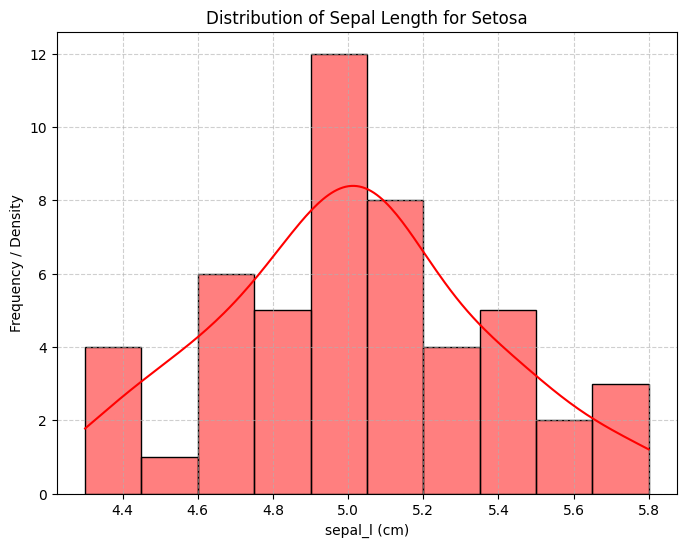

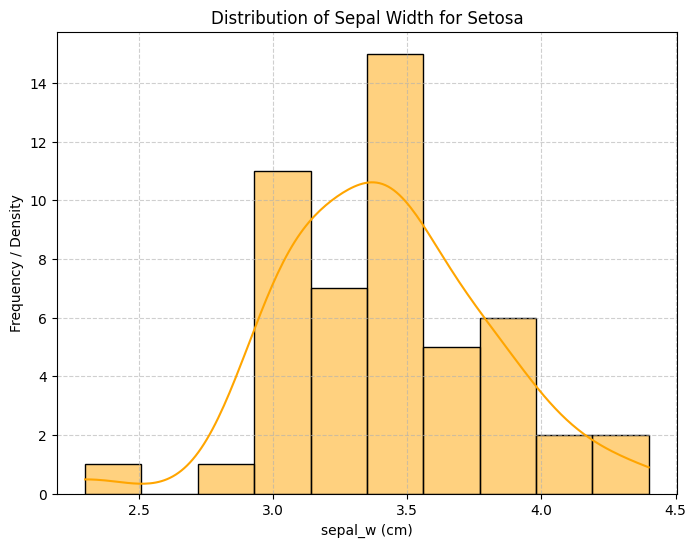

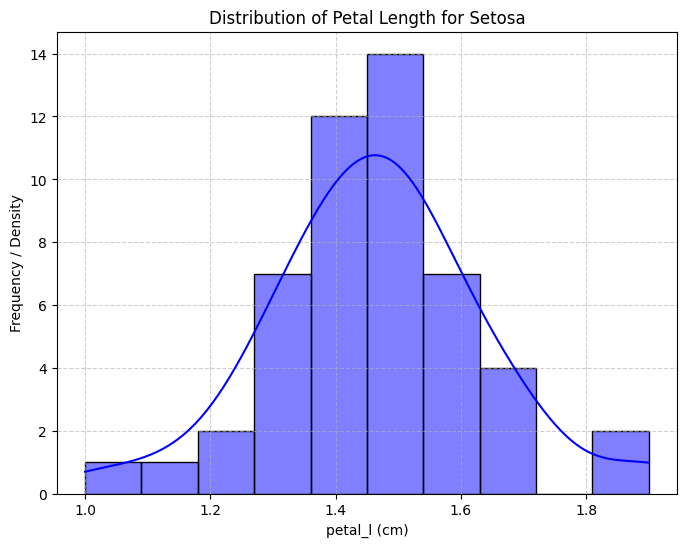

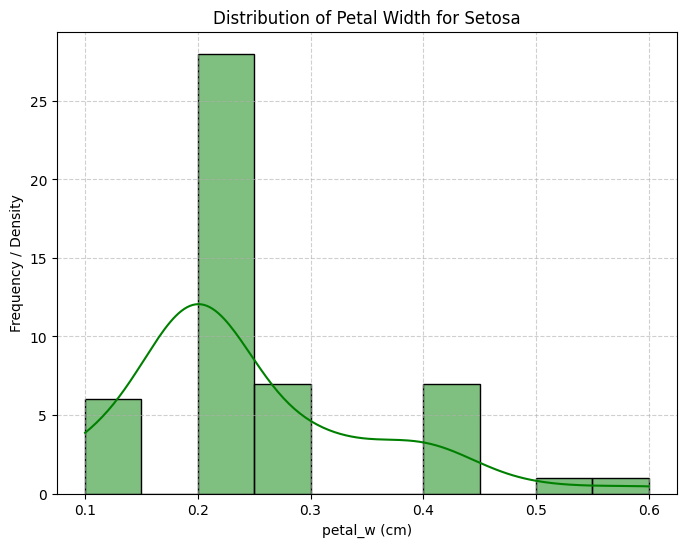

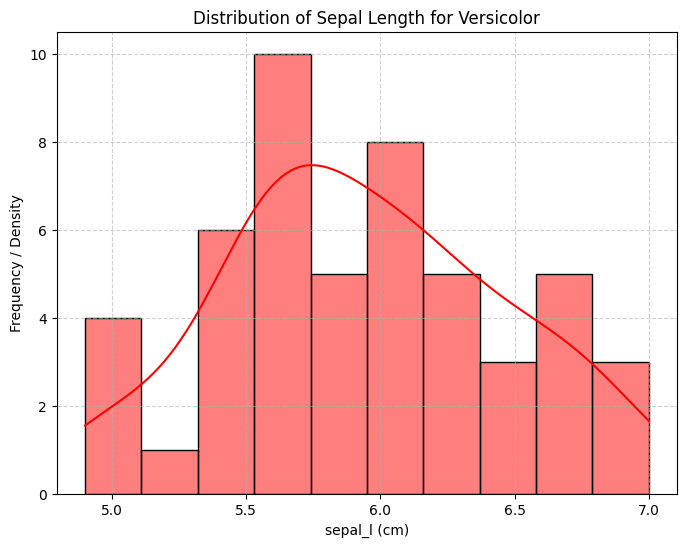

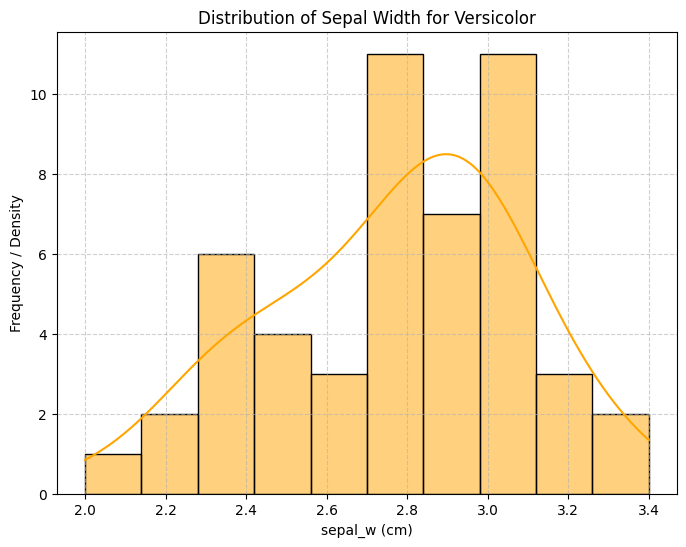

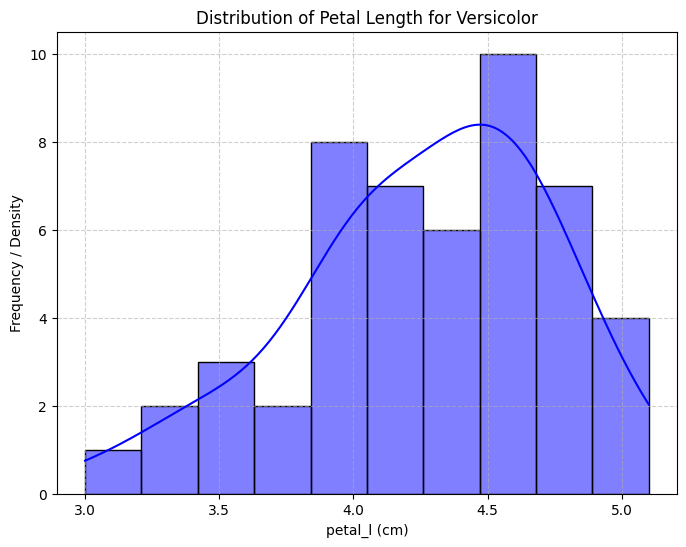

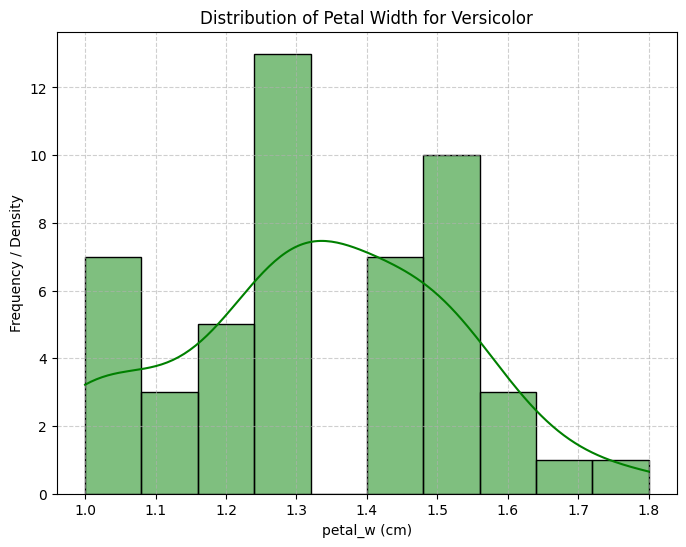

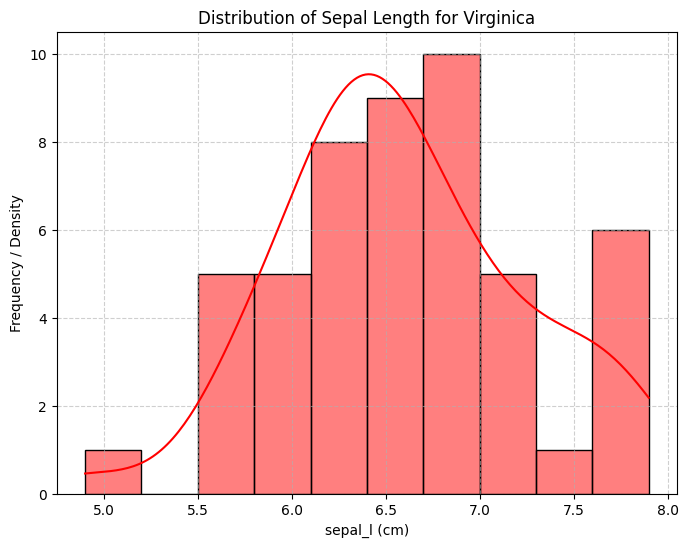

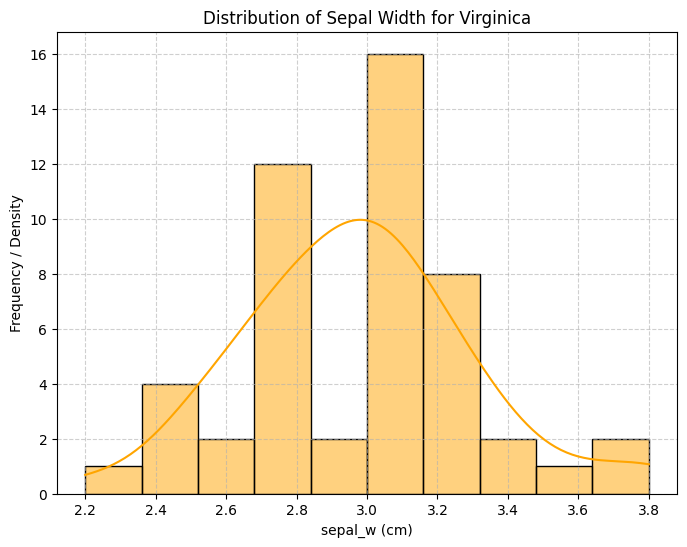

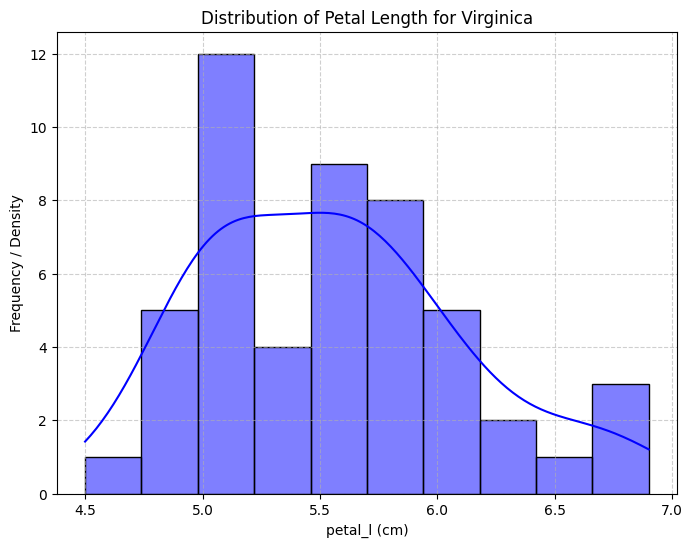

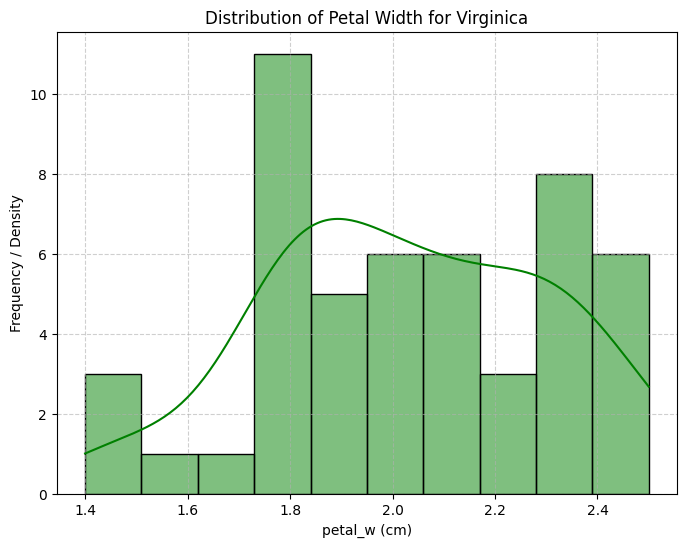

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

species_dfs = [df_setosa, df_versicolor, df_virginica]
species_names = ['Setosa', 'Versicolor', 'Virginica']
features = ['sepal_l',	'sepal_w', 'petal_l',	'petal_w']
measurements = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']
colors = ['red', 'orange', 'blue', 'green']

print("Average Petal Area: ")
# 1. Approx mean petal area for each species
for i in range(3):
  species = species_dfs[i]
  species_name = species_names[i]
  avg_petal_area = species['petal_l'].mean() * species['petal_w'].mean()
  print(f"{species_name} = {avg_petal_area:.3} cm^2")
print("\n")

print("Average Sepal Area: ")
# 1. Approx mean petal area for each species
for i in range(3):
  species = species_dfs[i]
  species_name = species_names[i]
  avg_petal_area = species['sepal_l'].mean() * species['sepal_w'].mean()
  print(f"{species_name} = {avg_petal_area:.3} cm^2")
print("\n")

# 2. Create a histogram with KDE for each species and feature
for i in range(3):
  for j in range(4):
    feature = features[j]
    measurement = measurements[j]
    plt.figure(figsize=(8,6))
    species = species_dfs[i]
    species_name = species_names[i]
    sns.histplot(species[feature], kde=True, color=colors[j], bins=10)
    plt.title(f'Distribution of {measurement} for {species_name}')
    plt.xlabel(f'{feature} (cm)')
    plt.ylabel('Frequency / Density')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f"graphs/{species_name}-{feature}-dist.png")
    plt.show()

# 3. Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split
# 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    labels,
                                                    test_size=0.3,
                                                    random_state=rs)


# 4. Fit Models & Evaluate Results

## a. Classification Performance with Cross-Validation

To get a more reliable estimate of our models' performance and to mitigate sampling bias from a single train-test split, we'll implement Stratified K-Fold Cross-Validation. This technique ensures that each fold maintains the same proportion of target labels as the original dataset, which is crucial for imbalanced datasets and robust evaluation.

The following function `perform_stratified_kfold_cv` will execute the cross-validation process.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def perform_stratified_kfold_cv(models, data, labels, n_splits=5, random_state=None):
    """
    Performs Stratified K-Fold Cross-Validation for a list of models.

    Args:
        models (dict): A dictionary where keys are model names (str) and values are initialized model objects.
        data (np.ndarray): The feature data.
        labels (pd.Series or np.ndarray): The target labels.
        n_splits (int): The number of folds for cross-validation.
        random_state (int): Seed for reproducibility.

    Returns:
        dict: A dictionary containing lists of accuracy, precision, recall, and F1 scores
              for each model across all folds.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    all_metrics = {name: {'accuracy': [], 'precision': [], 'recall': [], 'f1': []} for name in models.keys()}

    for fold, (train_index, test_index) in enumerate(skf.split(data, labels)):
        X_train_fold, X_test_fold = data[train_index], data[test_index]
        y_train_fold, y_test_fold = labels.iloc[train_index], labels.iloc[test_index]

        # Scale data for the current fold
        scaler_cv = StandardScaler()
        X_train_fold_scaled = scaler_cv.fit_transform(X_train_fold)
        X_test_fold_scaled = scaler_cv.transform(X_test_fold)

        for model_name, model in models.items():
            # Ensure the model is re-initialized or cloned if it maintains state across fits
            # For simple models like KNN/DT, re-fitting is usually fine.
            # For more complex models, consider `clone(model)` if hyperparameters are fixed.
            model.fit(X_train_fold_scaled, y_train_fold)
            y_pred_cv = model.predict(X_test_fold_scaled)

            all_metrics[model_name]['accuracy'].append(accuracy_score(y_test_fold, y_pred_cv))
            all_metrics[model_name]['precision'].append(precision_score(y_test_fold, y_pred_cv, average='macro'))
            all_metrics[model_name]['recall'].append(recall_score(y_test_fold, y_pred_cv, average='macro'))
            all_metrics[model_name]['f1'].append(f1_score(y_test_fold, y_pred_cv, average='macro'))

    return all_metrics

After performing the cross-validation, we need a way to summarize the results. The `print_average_cv_results` function will calculate and display the mean and standard deviation for each metric across all folds, giving us an overall picture of model performance and its variability.

In [ ]:
def print_average_cv_results(cv_metrics):
    """
    Prints the average and standard deviation of classification metrics from cross-validation.

    Args:
        cv_metrics (dict): A dictionary containing lists of metrics for each model and fold.
    """
    print("Average Metrics (Stratified 5-Fold Cross-Validation):")
    for model_name, metrics in cv_metrics.items():
        print(f"\n{model_name} Average Metrics:")
        for metric_name, scores in metrics.items():
            mean_score = np.mean(scores)
            std_score = np.std(scores)
            print(f"  {metric_name.replace('_', ' ').title()} = {mean_score:.4f} ± {std_score:.4f}")

Now, let's run the cross-validation using the defined functions and see the average performance metrics for our KNN and Decision Tree models.

In [ ]:
# Define the models to be used for cross-validation
models = {
    "3-NN": KNeighborsClassifier(n_neighbors=3),
    "Decision Tree": DecisionTreeClassifier(random_state=rs)
}

# Perform cross-validation
cv_results = perform_stratified_kfold_cv(models, data, labels, n_splits=5, random_state=rs)

# Print the average results
print_average_cv_results(cv_results)


--- Average Metrics (Stratified K-Fold Cross-Validation) ---

3-NN Average Metrics:
  Accuracy: 0.9533 ± 0.0340
  Precision: 0.9560 ± 0.0322
  Recall: 0.9533 ± 0.0340
  F1: 0.9532 ± 0.0341

Decision Tree Average Metrics:
  Accuracy: 0.9333 ± 0.0422
  Precision: 0.9432 ± 0.0324
  Recall: 0.9333 ± 0.0422
  F1: 0.9321 ± 0.0439


## b. Confusion matrices

Apply StandardScaler to the `X_train` and `X_test` datasets, which were created during the initial train-test split. This will generate `X_train_scaled` and `X_test_scaled` variables, making them available for model fitting and prediction for the confusion matrices.


In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled and X_test_scaled have been created.")

X_train_scaled and X_test_scaled have been created.


In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=3)
dt_model = DecisionTreeClassifier(random_state=rs)

knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)

dt_model.fit(X_train_scaled, y_train)
dt_pred = dt_model.predict(X_test_scaled)

print("Models fitted and predictions made on scaled data.")

Models fitted and predictions made on scaled data.


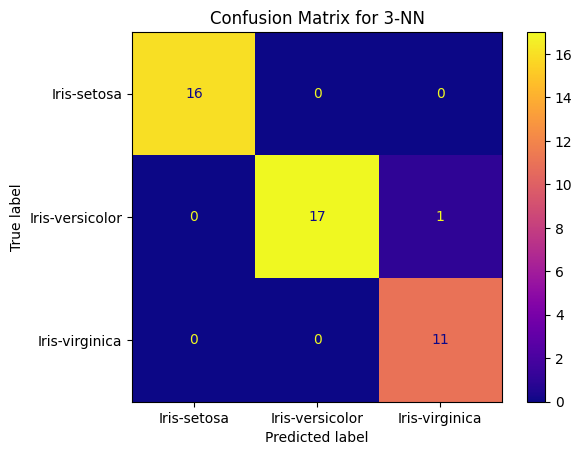

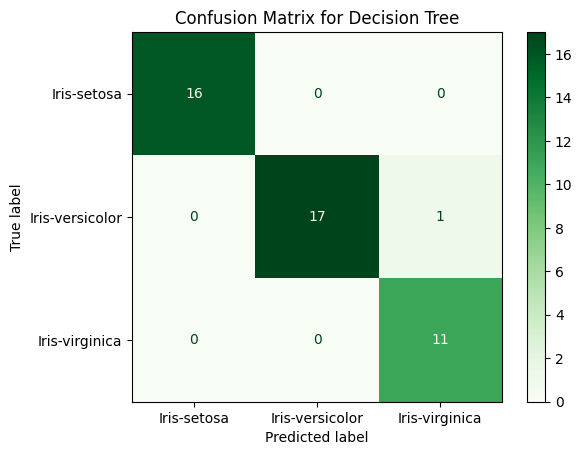

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set labels for disp on CM
labels = ['Iris-setosa','Iris-versicolor','Iris-virginica']

# Create & Display 3-NN CM
knn_matrix = confusion_matrix(y_test, knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=knn_matrix, display_labels=labels)
disp.plot(cmap='plasma')
disp.ax_.set_title("Confusion Matrix for 3-NN")
plt.show()

# Create & Display DT CM
dt_matrix = confusion_matrix(y_test, dt_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=dt_matrix, display_labels=labels)
disp.plot(cmap='Greens')
disp.ax_.set_title("Confusion Matrix for Decision Tree")
plt.show()